# Модели на основе трансформеров. Оценка качества

In [ ]:
!pip install transformers[sentencepiece] datasets evaluate accelerate xformers

In [2]:
# Монтирование google-диска
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Проверка доступной видеокарты
!nvidia-smi

Mon Jun 12 18:41:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer
from evaluate.visualization import radar_plot

import numpy as np
import pandas as pd
import evaluate
import time
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='whitegrid')

In [11]:
models_name = ["BERT", "distilBERT", "RoBERTa", "DeBERTa v3"] 
models_path =[
   "drive/MyDrive/models/BERT/BERT_best_model/",
    "drive/MyDrive/models/distilBERT/distilBERT_best_model/",
    "drive/MyDrive/models/RoBERTa/RoBERTa_best_model/",
    "drive/MyDrive/models/DeBERTa/DeBERTa_best_model/"
]

In [ ]:
# Создание тестового датасета
data = load_dataset("csv", data_files="issue_data_encoded_small.csv", data_dir="drive/MyDrive/datasets")
data = data['train'].train_test_split(test_size=0.2, seed=2)
test_data = data['test']

In [7]:
test_data

Dataset({
    features: ['labels', 'text'],
    num_rows: 16000
})

In [ ]:
# Загрузка метрик
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
classification_report_metric = evaluate.load("bstrai/classification_report")

In [9]:
def label_to_num(label):
    if label == 'bug':
        number = 0
    elif label == 'enhancement':
        number = 1
    elif label == 'documentation':
        number = 2
    else:
        number = 3
    return number

In [12]:
# Оценка качества моделей
classification_reports = []
f1_classes = []
f1_micro = []
precision_micro = []
rec_micro = []

for model in models_path:
    classifier = pipeline("text-classification", model=model, tokenizer=AutoTokenizer.from_pretrained(model), device=0)

    start_time = time.time()
    pred = classifier(test_data['text'], padding=True, truncation=True, max_length=384)
    print(f"{models_name[models_path.index(model)]}: {time.time() - start_time} секунд \n")

    pred_list = [pred[i]['label'] for i in range(0, len(pred))]
    pred_list = list(map(label_to_num, pred_list))

    classification_reports.append(classification_report_metric.compute(references=test_data["labels"],
                                                                       predictions=pred_list,
                                                                       target_names=["bug", "enhancement", "documentation", "question"]))

    precision_micro.append(precision.compute(references=test_data["labels"],
                               predictions=pred_list,
                               average="micro"))
    rec_micro.append(recall.compute(references=test_data["labels"],
                               predictions=pred_list,
                               average="micro"))
    f1_micro.append(f1.compute(references=test_data["labels"],
                               predictions=pred_list,
                               average="micro"))

    f1_classes.append(f1.compute(references=test_data["labels"],
                               predictions=pred_list,
                               average=None))

BERT: 221.1273763179779 секунд 

distilBERT: 124.05532908439636 секунд 

RoBERTa: 222.2034456729889 секунд 



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DeBERTa v3: 392.8438923358917 секунд 



In [13]:
classification_reports_df = [pd.DataFrame(classification_report).transpose() for classification_report in classification_reports]

In [14]:
# BERT
classification_reports_df[0]

,precision,recall,f1-score,support
bug,0.816582,0.878426,0.846375,4014.00000
enhancement,0.842606,0.865197,0.853752,3991.00000
documentation,0.887758,0.859749,0.873529,4057.00000
question,0.845144,0.784408,0.813644,3938.00000
accuracy,0.847250,0.847250,0.847250,0.84725
macro avg,0.848022,0.846945,0.846825,16000.00000
weighted avg,0.848151,0.847250,0.847044,16000.00000


In [15]:
# distilBERT
classification_reports_df[1]

,precision,recall,f1-score,support
bug,0.815880,0.890882,0.851733,4014.000000
enhancement,0.852868,0.864194,0.858494,3991.000000
documentation,0.915753,0.843973,0.878399,4057.000000
question,0.838289,0.816150,0.827072,3938.000000
accuracy,0.853938,0.853938,0.853938,0.853938
macro avg,0.855697,0.853800,0.853924,16000.000000
weighted avg,0.855946,0.853938,0.854111,16000.000000


In [16]:
# RoBERTa
classification_reports_df[2]

,precision,recall,f1-score,support
bug,0.847073,0.865222,0.856051,4014.0000
enhancement,0.849491,0.878226,0.863620,3991.0000
documentation,0.911935,0.855065,0.882585,4057.0000
question,0.828463,0.835196,0.831816,3938.0000
accuracy,0.858500,0.858500,0.858500,0.8585
macro avg,0.859241,0.858427,0.858518,16000.0000
weighted avg,0.859542,0.858500,0.858702,16000.0000


In [17]:
# DeBERTa v3
classification_reports_df[3]

,precision,recall,f1-score,support
bug,0.858037,0.853762,0.855894,4014.00000
enhancement,0.860825,0.878727,0.869684,3991.00000
documentation,0.896196,0.876756,0.886369,4057.00000
question,0.825889,0.831133,0.828503,3938.00000
accuracy,0.860250,0.860250,0.860250,0.86025
macro avg,0.860237,0.860094,0.860112,16000.00000
weighted avg,0.860496,0.860250,0.860319,16000.00000


In [18]:
acc_list = [classification_reports[i]["accuracy"] for i in range(0, len(models_name))]

In [19]:
f1_bug = [f1_classes[i]["f1"][0] for i in range(0, len(models_name))]
f1_enh = [f1_classes[i]["f1"][1] for i in range(0, len(models_name))]
f1_doc = [f1_classes[i]["f1"][2] for i in range(0, len(models_name))]
f1_que = [f1_classes[i]["f1"][3] for i in range(0, len(models_name))]
f1_avg = [f1_micro[i]["f1"] for i in range(0, len(models_name))]

In [20]:
metrics_data = pd.DataFrame(data={"model" : models_name,
                                  "accuracy": acc_list,
                                  "f1_avg" : f1_avg,
                                  "f1_bug" : f1_bug,
                                  "f1_enh" : f1_enh,
                                  "f1_doc" : f1_doc,
                                  "f1_que" : f1_que,
                                  "extra_processed": False},
                            index=np.arange(0, 4)
                            )

In [21]:
metrics_data

,model,accuracy,f1_avg,f1_bug,f1_enh,f1_doc,f1_que,extra_processed
0,BERT,0.847250,0.847250,0.846375,0.853752,0.873529,0.813644,False
1,distilBERT,0.853938,0.853938,0.851733,0.858494,0.878399,0.827072,False
2,RoBERTa,0.858500,0.858500,0.856051,0.863620,0.882585,0.831816,False
3,DeBERTa v3,0.860250,0.860250,0.855894,0.869684,0.886369,0.828503,False


In [22]:
# Сохранение датасета
metrics_data.to_csv("drive/MyDrive/datasets/transformers.csv", sep=",", index=False)

In [23]:
metrics_to_show = metrics_data.copy()
metrics_to_show = metrics_to_show.rename(columns={"f1_bug" : "bug", "f1_enh": "enhancement", "f1_doc" : "documentation", "f1_que" : "question"})
metrics_to_show

,model,accuracy,f1_avg,bug,enhancement,documentation,question,extra_processed
0,BERT,0.847250,0.847250,0.846375,0.853752,0.873529,0.813644,False
1,distilBERT,0.853938,0.853938,0.851733,0.858494,0.878399,0.827072,False
2,RoBERTa,0.858500,0.858500,0.856051,0.863620,0.882585,0.831816,False
3,DeBERTa v3,0.860250,0.860250,0.855894,0.869684,0.886369,0.828503,False


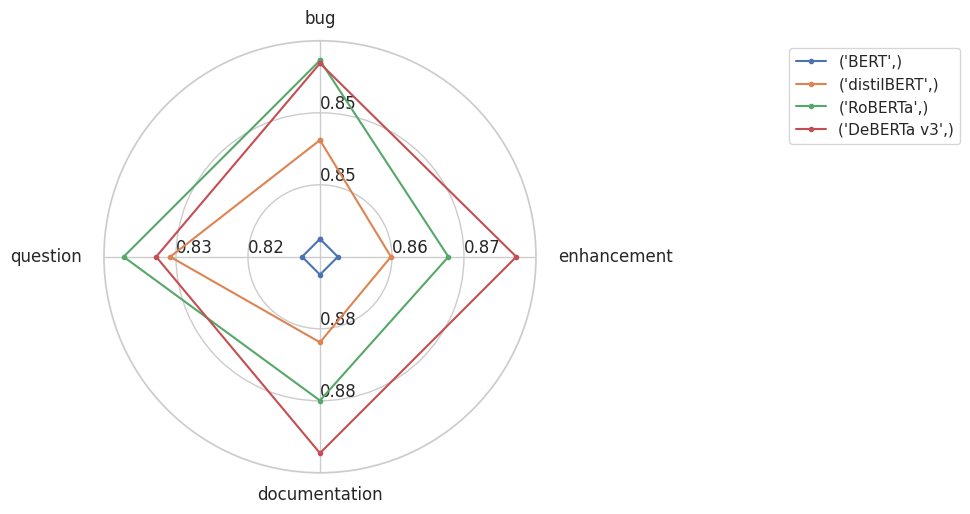

In [24]:
# F-мера по классам
r = radar_plot(metrics_to_show[["bug", "enhancement", "documentation", "question"]], model_names=metrics_to_show.model)
plt.show()

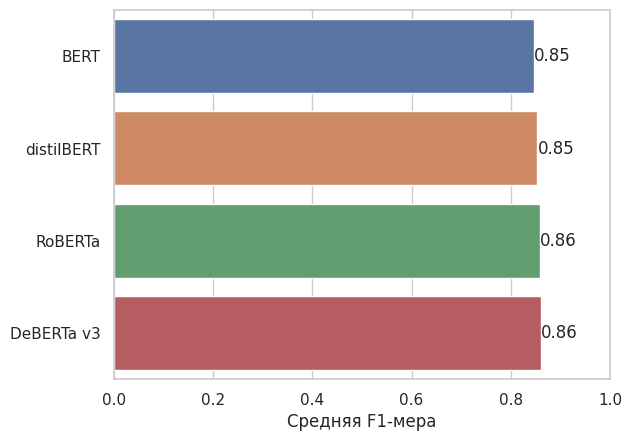

In [25]:
_, ax = plt.subplots()
bar = sns.barplot(metrics_data, x="f1_avg", y="model")
ax.set_xlim(0, 1)
ax.set_xlabel("Средняя F1-мера")
ax.set_ylabel("")
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.show()

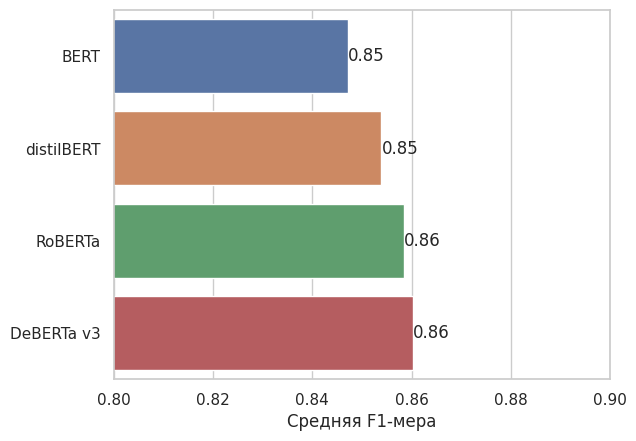

In [26]:
_, ax = plt.subplots()
bar = sns.barplot(metrics_data, x="f1_avg", y="model")
ax.set_xlim(0.8, 0.9)
ax.set_xlabel("Средняя F1-мера")
ax.set_ylabel("")
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.show()

In [27]:
metrics_melt = metrics_to_show.copy()
metrics_melt = metrics_melt.melt(id_vars=["model", "extra_processed"],
                                 value_vars=["bug", "enhancement", "documentation", "question"],
                                 var_name="label")
metrics_melt

,model,extra_processed,label,value
0,BERT,False,bug,0.846375
1,distilBERT,False,bug,0.851733
2,RoBERTa,False,bug,0.856051
3,DeBERTa v3,False,bug,0.855894
4,BERT,False,enhancement,0.853752
5,distilBERT,False,enhancement,0.858494
6,RoBERTa,False,enhancement,0.863620
7,DeBERTa v3,False,enhancement,0.869684
8,BERT,False,documentation,0.873529
9,distilBERT,False,documentation,0.878399


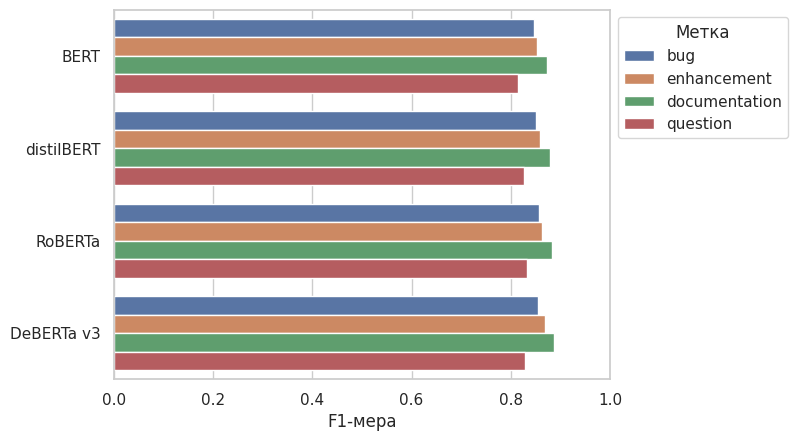

In [28]:
_, ax = plt.subplots()
bar = sns.barplot(metrics_melt,
                  x="value", y="model", hue="label")
ax.set_xlim(0, 1)
ax.set_xlabel("F1-мера")
ax.set_ylabel("")
ax.get_legend().set_title('Метка')
sns.move_legend(bar, "upper left", bbox_to_anchor=(1, 1))
plt.show()

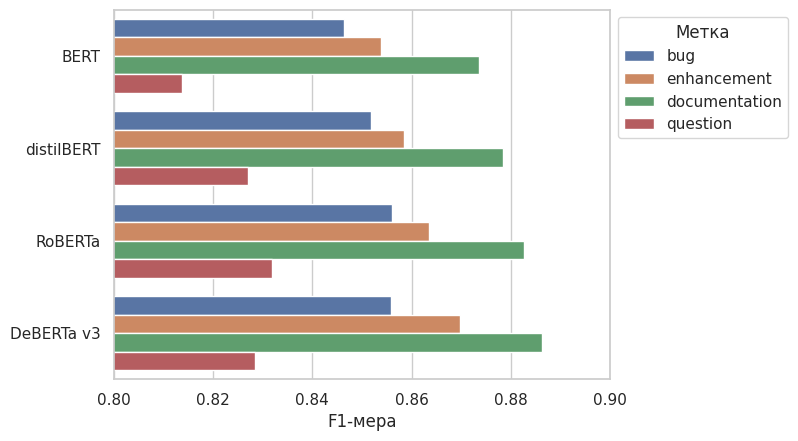

In [29]:
_, ax = plt.subplots()
bar = sns.barplot(metrics_melt,
                  x="value", y="model", hue="label")
ax.set_xlim(0.8, 0.9)
ax.set_xlabel("F1-мера")
ax.set_ylabel("")
ax.get_legend().set_title('Метка')
sns.move_legend(bar, "upper left", bbox_to_anchor=(1, 1))
plt.show()